# Data Cleaning & Preprocessing

In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv("credit_risk_dataset.csv")

In [39]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.659427,9593.845632,11.014662,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.162406,6322.730241,3.083050,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [38]:
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,False,False,...,False,True,False,False,True,False,False,False,False,False
32577,54,120000,4.0,17625,7.49,0,0.15,19,False,False,...,False,True,False,False,False,False,False,False,False,False
32578,65,76000,3.0,35000,10.99,1,0.46,28,False,False,...,False,False,False,True,False,False,False,False,False,False
32579,56,150000,5.0,15000,11.48,0,0.10,26,False,False,...,False,True,False,True,False,False,False,False,False,False


In [33]:
df.drop_duplicates(inplace=True)

# Handle missing values
df.fillna({"person_emp_length": 0,"loan_int_rate": df["loan_int_rate"].median()}, inplace=True)


 # Encode Categorical Features

In [34]:
df = pd.get_dummies(df, drop_first=True)

In [35]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]


# Train Models

In [55]:
#Logistic Regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [57]:
#CatBoost
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)


In [58]:
#Get Probabilities
y_prob = cat.predict_proba(X_test)[:,1]

In [42]:
FP_COST = 1
FN_COST = 10

In [44]:
from sklearn.metrics import confusion_matrix

In [59]:
#Threshold Optimization
thresholds = np.arange(0.1, 0.9, 0.01)

best_cost = float("inf")
best_thresh = 0.5

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    cost = fp*FP_COST + fn*FN_COST
    
    if cost < best_cost:
        best_cost = cost
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Minimum Cost:", best_cost)


Best Threshold: 0.1
Minimum Cost: 2502


 # Feature Importance

In [46]:

importance = pd.Series(lr.coef_[0], index=X.columns)
importance.sort_values(ascending=False).head(10)

loan_grade_E                   1.338371
loan_percent_income            1.075308
loan_grade_D                   1.068469
person_home_ownership_RENT     0.786623
loan_grade_F                   0.544884
loan_grade_G                   0.268410
loan_intent_HOMEIMPROVEMENT    0.260869
cb_person_default_on_file_Y    0.252852
loan_int_rate                  0.167221
person_home_ownership_OTHER    0.087844
dtype: float64

In [47]:
feat_imp = pd.Series(cat.get_feature_importance(),index=X.columns).sort_values(ascending=False)

print(feat_imp.head(10))


loan_percent_income            27.046610
person_home_ownership_RENT     14.332936
person_income                  14.058688
loan_grade_D                    7.117309
loan_int_rate                   6.930941
person_emp_length               5.109493
person_home_ownership_OWN       4.829628
loan_intent_VENTURE             3.562823
loan_intent_HOMEIMPROVEMENT     3.495519
loan_amnt                       2.583368
dtype: float64


# Move from “Modeling” → “Risk Framework”

In [48]:
def risk_band(p):
    if p < 0.3:
        return "Low Risk"
    elif p < 0.6:
        return "Medium Risk"
    else:
        return "High Risk"


  Using cached catboost-1.2.8-cp310-cp310-win_amd64.whl.metadata (1.5 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   --------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\catboost\\_catboost.pyd'
Consider using the `--user` option or check the permissions.



  Using cached catboost-1.2.8-cp310-cp310-win_amd64.whl.metadata (1.5 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.5 MB 409.0 kB/s eta 0:04:10
   ---------------------------------------- 0.8/102.5 MB 599.2 kB/s eta 0:02:50
   ---------------------------------------- 0.8/102.5 MB 599.2 kB/s eta 0:02:50
   ---------------------------------------- 1.0/102.5 MB 592.2 kB/s eta 0:02:52
   ---------------------------------------- 1.0/102.5 MB 592.2 kB/s eta 0:02:52
    --------------------------------------- 1.3/102.5 MB 583.5 kB/s eta 0:02:54
    ------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\catboost\\_catboost.pyd'
Consider using the `--user` option or check the permissions.



| Prob | Risk   | Decision |
| ---- | ------ | -------- |
| 0.12 | Low    | Approve  |
| 0.48 | Medium | Review   |
| 0.82 | High   | Reject   |


Stratified Cross-Validation

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(cat, X, y, cv=skf, scoring="roc_auc")

print("Mean ROC-AUC:", scores.mean())


Mean ROC-AUC: 0.9199795501845374


In [50]:
from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(cat, method="isotonic")
calibrated.fit(X_train, y_train)


,estimator,<catboost.cor...002816877DC00>
,method,'isotonic'
,cv,None
,n_jobs,None
,ensemble,'auto'


In [52]:
profit = (tp * 500) - (fn * 2000)

# Model Explainability using shap

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


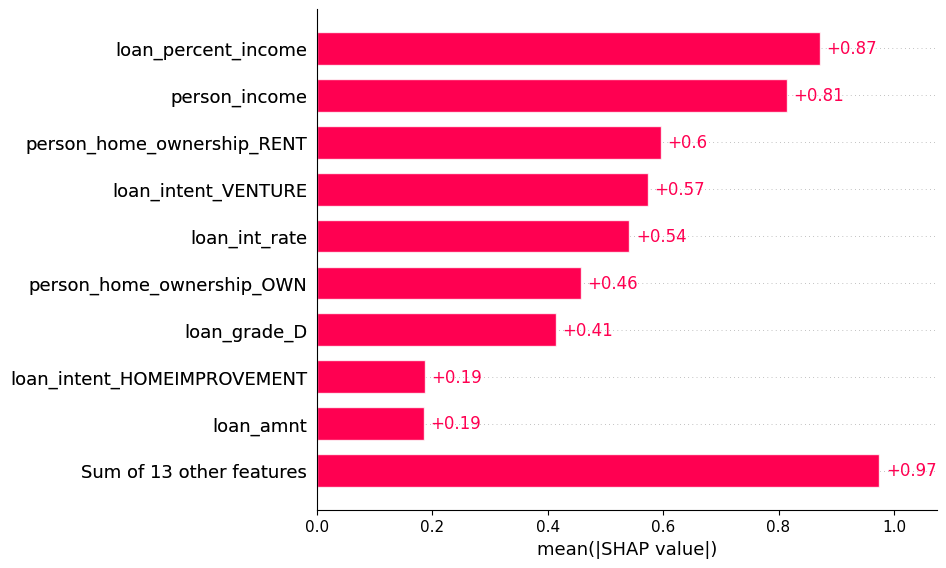

In [53]:
import shap

explainer = shap.Explainer(cat)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)


In [60]:
#Fairness Analysis
df["age_group"] = pd.cut(df["person_age"], bins=[18,30,50,80])

df.groupby("age_group")["loan_status"].mean()


C:\Users\Admin\AppData\Local\Temp\ipykernel_16964\542104948.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("age_group")["loan_status"].mean()


age_group
(18, 30]    0.222826
(30, 50]    0.203649
(50, 80]    0.259786
Name: loan_status, dtype: float64